In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pyspark.sql.functions import concat, to_timestamp, col, lit

In [2]:

# Import necessary libraries
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as spark_sum, col, hour, concat_ws, to_date, date_format
# Stop any existing Spark session
# Step 1: Initialize a Spark session
spark = SparkSession.builder \
    .appName("BigDataProcessing") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
# Step 2: Load your CSV file into a Spark DataFrame
data = spark.read.csv("June2024.csv", header=True, inferSchema=True)


your 131072x1 screen size is bogus. expect trouble
24/11/07 18:54:47 WARN Utils: Your hostname, J4Hp resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/11/07 18:54:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/07 18:54:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql.functions import to_timestamp, concat, col, lit, date_format, expr
# Filter rows where ROUTE_ID is 'acwXkRFM'
# data = data.filter(col("ROUTE_ID") == 'acwXkRFM')
# Step 2: Format TICKET_ISSUE_TIME as a string in "HH:mm:ss" format (if not already) and combine date and time
data = data.withColumn("TICKET_ISSUE_TIME_STR", date_format(col("TICKET_ISSUE_TIME"), "HH:mm:ss"))
data = data.withColumn("TICKET_DATETIME_STR", concat(col("TICKET_ISSUE_DATE"), lit(" "), col("TICKET_ISSUE_TIME_STR")))

# Step 3: Convert the combined date-time string to a timestamp format
data = data.withColumn("TICKET_DATETIME", to_timestamp("TICKET_DATETIME_STR", "dd/MM/yyyy HH:mm:ss"))

# Step 4: Round TICKET_DATETIME to the nearest 10-minute interval
data = data.withColumn("TICKET_DATETIME_10MIN", expr("date_trunc('minute', TICKET_DATETIME) + INTERVAL 10 MINUTE * floor(minute(TICKET_DATETIME) / 10)"))


In [4]:
# print("Schema after adding TICKET_DATETIME:")
# data.printSchema()
data.show(5)

+--------------------+-----------------+-------------------+--------------+---------------+------------+----------+--------+-----------+------------+---------+-----------------+--------------------+-----------+-----------+----------+------+---------------+---------------+-------+------------+---------------------+-------------------+-------------------+---------------------+
|          DEPOT_NAME|TICKET_ISSUE_DATE|  TICKET_ISSUE_TIME|WAYBILL_NUMBER|SCHEDULE_NUMBER|SERVICE_TYPE|ROUTE_NAME|ROUTE_ID|TRIP_NUMBER|          ID|TICKET_NO|   FROM_STOP_NAME|        TO_STOP_NAME|NO_OF_ADULT|NO_OF_CHILD|NO_OF_LUGG|OTHERS|TOTAL_PASSENGER|DISTANCE_TRAVEL|TRIP_KM|PAYMENT_TYPE|TICKET_ISSUE_TIME_STR|TICKET_DATETIME_STR|    TICKET_DATETIME|TICKET_DATETIME_10MIN|
+--------------------+-----------------+-------------------+--------------+---------------+------------+----------+--------+-----------+------------+---------+-----------------+--------------------+-----------+-----------+----------+------+----

In [5]:
# # Group by TICKET_DATETIME, FROM_STOP_NAME, and TO_STOP_NAME, and sum the TOTAL_PASSENGER
aggregated_data_from = (
    data.groupBy("TICKET_DATETIME_10MIN", "FROM_STOP_NAME")
    .sum("TOTAL_PASSENGER")
    .withColumnRenamed("sum(TOTAL_PASSENGER)", "TOTAL_PASSENGER")
)
# Sort by TICKET_DATETIME_5MIN
aggregated_data_from = aggregated_data_from.orderBy("TICKET_DATETIME_10MIN")
aggregated_data_from.show(500)


+---------------------+--------------------+---------------+
|TICKET_DATETIME_10MIN|      FROM_STOP_NAME|TOTAL_PASSENGER|
+---------------------+--------------------+---------------+
|  2024-05-31 01:45:00|    Peroorkada Depot|              1|
|  2024-05-31 01:46:00|    Peroorkada Depot|              9|
|  2024-05-31 01:47:00|    Peroorkada Depot|              1|
|  2024-05-31 01:47:00|         Ambalamukku|              5|
|  2024-05-31 01:48:00|         Ambalamukku|              7|
|  2024-05-31 01:49:00|         Ambalamukku|              1|
|  2024-05-31 02:00:00|   Pattom Sut Office|              1|
|  2024-05-31 02:00:00|         Kumarapuram|              2|
|  2024-05-31 02:00:00|         Ambalamukku|              3|
|  2024-05-31 02:00:00|             Kowdiar|              3|
|  2024-05-31 02:01:00|   Pattom Sut Office|              3|
|  2024-05-31 02:01:00|         Ambalamukku|              3|
|  2024-05-31 02:01:00|East Fort South B...|              3|
|  2024-05-31 02:01:00| 

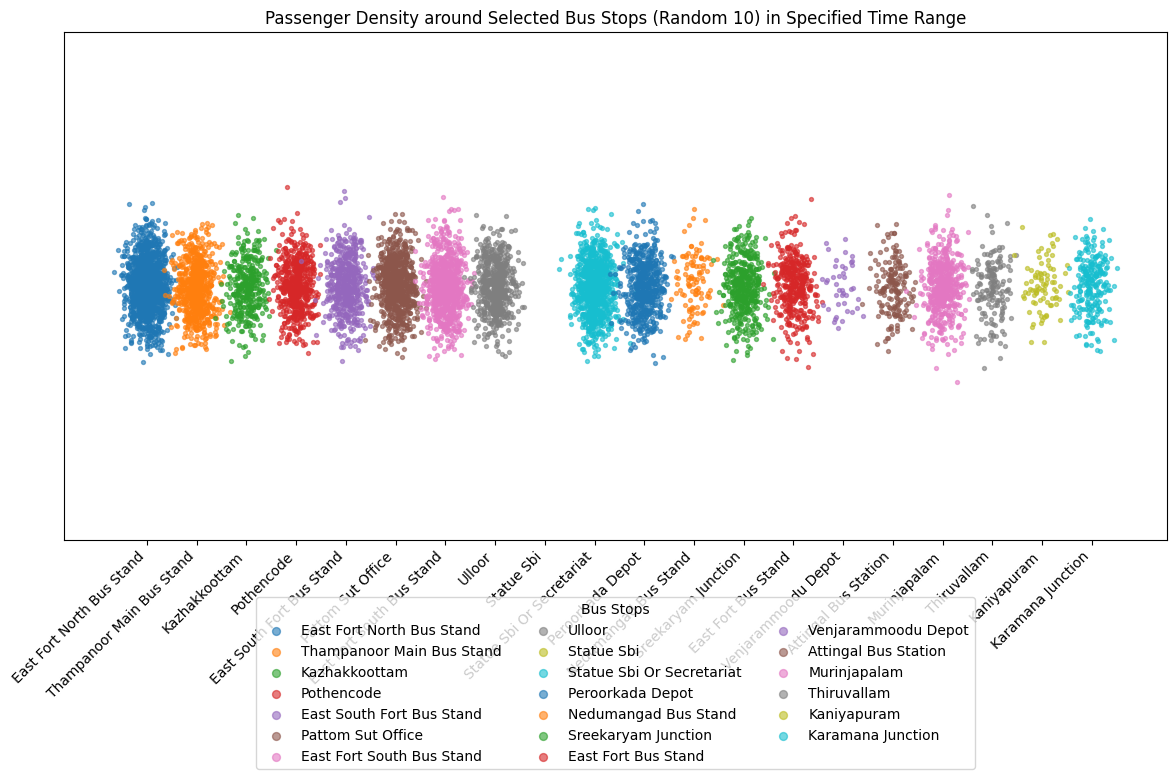

In [19]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np

# Define the specific time range
start_time = "2024-06-05 06:45:00"
end_time = "2024-06-05 09:45:00"

# Aggregate data to get total passenger count per bus stop within the time range
# Sort by total passengers in descending order and select the top 10
top_bus_stops = (
    aggregated_data_from.groupBy("FROM_STOP_NAME")
    .agg(F.sum("TOTAL_PASSENGER").alias("TOTAL_PASSENGER"))
    .orderBy("TOTAL_PASSENGER", ascending=False)
    .limit(20)
    .collect()
)
selected_stops = [stop["FROM_STOP_NAME"] for stop in top_bus_stops]

# Filter data for only the selected bus stops and within the specific time range
filtered_data = aggregated_data_from.filter(
    (col("FROM_STOP_NAME").isin(selected_stops)) &
    (col("TICKET_DATETIME_10MIN") >= start_time) &
    (col("TICKET_DATETIME_10MIN") <= end_time)
)

# Aggregate data to sum up passengers at each stop within the time range
aggregated_stop_data = (
    filtered_data.groupBy("FROM_STOP_NAME")
    .agg(F.sum("TOTAL_PASSENGER").alias("TOTAL_PASSENGER"))
    .collect()
)

# Map bus stops to passenger counts
stop_passenger_data = {row["FROM_STOP_NAME"]: row["TOTAL_PASSENGER"] for row in aggregated_stop_data}

# Plot setup with improved spacing
fig, ax = plt.subplots(figsize=(12, 8))

# Define positions for each bus stop on the x-axis and adjust for better spacing
x_positions = np.arange(len(selected_stops))  # Equally space each stop
stop_positions = dict(zip(selected_stops, x_positions))

# Scatter dots vertically around each bus stop based on passenger count
for stop, x_pos in stop_positions.items():
    # Generate random points around each bus stop
    num_passengers = stop_passenger_data.get(stop, 0)
    x_points = np.random.normal(loc=x_pos, scale=0.2, size=num_passengers)  # Narrower spread
    y_points = np.random.normal(loc=0, scale=0.5, size=num_passengers)  # More spread on y-axis for clarity

    # Plot each bus stop as a cluster of dots
    ax.scatter(x_points, y_points, alpha=0.6, s=8, label=stop)

# Update the x-axis tick positions and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(selected_stops, rotation=45, ha="right")

# Remove y-axis ticks since we are only interested in density (not actual values on y-axis)
ax.set_yticks([])

# Add a title and adjust the y-axis range to spread clusters more evenly
ax.set_title("Passenger Density around Selected Bus Stops (Random 10) in Specified Time Range")
ax.set_ylim(-5, 5)

# Place the legend below the plot to avoid overlap with data points
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, title="Bus Stops", markerscale=2)

plt.tight_layout()
plt.show()


In [7]:
# !pip install seaborn
# !pip install py4j
!pip install dash plotly



Defaulting to user installation because normal site-packages is not writeable


In [8]:
# !pip install dash plotly
from dash import Dash, dcc, html
import plotly.express as px
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import col

# Define the specific time range
start_time = "2024-06-05 06:45:00"
end_time = "2024-06-05 09:45:00"

# Aggregate data to get total passenger count per bus stop within the time range
# Sort by total passengers in descending order and select the top 20
top_bus_stops = (
    aggregated_data_from.groupBy("FROM_STOP_NAME")
    .agg(F.sum("TOTAL_PASSENGER").alias("TOTAL_PASSENGER"))
    .orderBy("TOTAL_PASSENGER", ascending=False)
    .limit(20)
    .collect()
)
selected_stops = [stop["FROM_STOP_NAME"] for stop in top_bus_stops]

# Filter data for only the selected bus stops and within the specific time range
filtered_data = aggregated_data_from.filter(
    (col("FROM_STOP_NAME").isin(selected_stops)) &
    (col("TICKET_DATETIME_10MIN") >= start_time) &
    (col("TICKET_DATETIME_10MIN") <= end_time)
)

# Aggregate data to sum up passengers at each stop within the time range
aggregated_stop_data = (
    filtered_data.groupBy("FROM_STOP_NAME")
    .agg(F.sum("TOTAL_PASSENGER").alias("TOTAL_PASSENGER"))
    .collect()
)

# Convert Spark DataFrame to Pandas DataFrame for use in Plotly
data = pd.DataFrame(aggregated_stop_data)

# Prepare data for Plotly scatter plot
scatter_data = {
    "FROM_STOP_NAME": [],
    "x_position": [],
    "y_position": []
}

for row in aggregated_stop_data:
    stop_name = row["FROM_STOP_NAME"]
    total_passenger = row["TOTAL_PASSENGER"]
    x_position = selected_stops.index(stop_name)

    # Generate random scatter points for each passenger count
    x_points = np.random.normal(loc=x_position, scale=0.2, size=total_passenger)
    y_points = np.random.normal(loc=0, scale=0.5, size=total_passenger)

    scatter_data["FROM_STOP_NAME"].extend([stop_name] * total_passenger)
    scatter_data["x_position"].extend(x_points)
    scatter_data["y_position"].extend(y_points)

# Create a Pandas DataFrame from the scatter data
scatter_df = pd.DataFrame(scatter_data)

# Create a Plotly scatter plot
fig = px.scatter(
    scatter_df,
    x="x_position",
    y="y_position",
    color="FROM_STOP_NAME",
    labels={"x_position": "Bus Stops", "y_position": ""},
    title="Passenger Density around Selected Bus Stops in Specified Time Range",
    hover_data=["FROM_STOP_NAME"]
)

# Adjust layout for better readability
fig.update_layout(
    xaxis=dict(
        tickvals=list(range(len(selected_stops))),
        ticktext=selected_stops,
        tickangle=45
    ),
    yaxis=dict(showticklabels=False),
    legend_title="Bus Stops"
)

# Set up Dash application
app = Dash(__name__)
app.layout = html.Div([
    html.H1("Passenger Density Visualization"),
    dcc.Graph(figure=fig)
])

# Run the Dash app
if __name__ == "__main__":
    app.run_server(debug=True)


In [8]:
# # Downsample or take a subset
# sampled_data = aggregated_data_from.sample(fraction=0.1)  # adjust fraction as needed



In [9]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd


# # Convert Spark DataFrame to Pandas DataFrame for easier plotting
# sampled_data_pd  =  sampled_data.toPandas()  # Now it's small enough to fit in memory


# # Set up the plot
# plt.figure(figsize=(14, 8))

# # Plot with seaborn scatterplot to distinguish `FROM_STOP_NAME` by color
# sns.scatterplot(
#     data=sampled_data_pd ,
#     x="TICKET_DATETIME_10MIN",
#     y="TOTAL_PASSENGER",
#     hue="FROM_STOP_NAME",
#     palette="viridis",
#     s=50,  # size of the dots
#     edgecolor="k",  # add edge color for better visibility
#     alpha=0.7       # make dots slightly transparent
# )

# # Set title and labels
# plt.title("Passenger Counts by 10-Minute Intervals and Stop")
# plt.xlabel("Ticket Issue Time (10-Minute Intervals)")
# plt.ylabel("Total Passengers")
# plt.xticks(rotation=45)

# # Optional: add legend
# plt.legend(title="From Stop Name", bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show plot
# plt.tight_layout()
# plt.show()


In [10]:
# import plotly.express as px
# import pandas as pd

# # Assuming pandas_data has the aggregated data

# # Plot the scatter plot animation
# fig = px.scatter(
#     pandas_data,
#     x="FROM_STOP_NAME",  # or any other column for x-axis
#     y="TO_STOP_NAME",    # or any other column for y-axis
#     size="TOTAL_PASSENGER",  # bubble size represents the number of passengers
#     color="FROM_STOP_NAME",  # color by stop name to create clusters
#     animation_frame="TICKET_DATETIME",  # time-based animation
#     title="KSRTC Passenger Flow Between Stops Over Time",
#     labels={
#         "FROM_STOP_NAME": "From Stop",
#         "TO_STOP_NAME": "To Stop",
#         "TOTAL_PASSENGER": "Total Passengers"
#     },
# )

# # Show the plot
# fig.show()
